# Final model performance

In this notebook we run our best-performing model on the test set to get a final estimate of its performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from HelperFunctions import *

## Loading the data

In [2]:
df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')

We will now perform some imputation and scaling. It is important to note that all of the transformations we will perform here will be performed "within season," meaning that the data for a given season is transformed using information from ***only*** that season and no other.

In particular, since at the time of prediction we will have access to all of the data for that particular season, there is ***no data leakage*** occurring here.

In [3]:
df_train = ImputeAndScale(df_train)
df_test  = ImputeAndScale(df_test)

In [4]:
# select features
features = df_train.select_dtypes(include='number').columns.drop(['PLAYER_ID', 'SEASON_START', 'IN_LEAGUE_NEXT'])
print(features)

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')


## Testing model performance

### Performance metrics

We will use the following metrics in our evaluation:

* $\text{Balanced Accuracy} = \frac{\text{Recall} + \text{Specificity}}{2}$

* $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$

* $\text{Recall} = \text{Sensitivity} = \frac{\text{TP}}{\text{TP} + \text{FN}}$

* $\text{Negative Predictive Value (NPV)} = \frac{\text{TN}}{\text{TN} + \text{FN}}$

* $\text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}$

### Walk-forward testing

In order to get the most realistic estimate of our model performance, we will perform walk-forward testing. The idea is as follows:

0. **Initialize datasets**: Begin with training set `df_train` (seasons 1990-91 through 2016-17) and test set `df_test[df_test['SEASON_START']==2017]` (season 2017-18).

1. **Train the model**: Fit the model using the current training set.

2. **Evaluate performance**: Use the model to predict outcomes for the current test set and compute performance metrics.

3. **Itereate**: Expand the training set to include the current test set, replace the test set with data from the next season, and repeat from Step 1 until no future data is available.

See the following table for explicit details.

| Iteration | Training set start seasons | Test set start season |
| ---       | ---                        | ---                   |
| 1         | 1990 - 2016                | 2017                  |
| 2         | 1990 - 2017                | 2018                  |
| 3         | 1990 - 2018                | 2019                  |
| 4         | 1990 - 2019                | 2020                  |
| 5         | 1990 - 2020                | 2021                  |
| 6         | 1990 - 2021                | 2022                  |

We will write a function `test_model_performance` to implement this walk-forward testing for a given model.

### Baseline model

As a baseline model, we will consider the classifier which always predicts the majority class, which in this case is 1 (in other words it, always predicts that a player will return to the NBA the folowing year). This model should have a recall of 1 and a specificity of 0, therefore we should expect to see a balanced accuracy of 0.5.

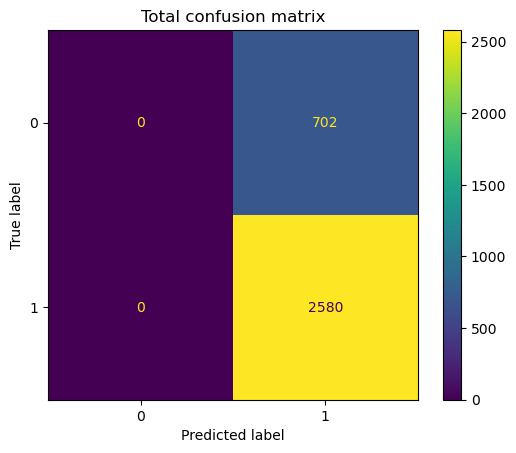

In [5]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent')

baseline_summary = test_model_performance(baseline_model, df_train, df_test, features)

In [6]:
baseline_summary

,Test Year,Balanced accuracy,Precision,Recall,NPV,Specificity,Uncalibrated Brier,Calibrated Brier
0,2017,0.5,0.762963,1.0,0.0,0.0,0.237037,0.183011
1,2018,0.5,0.754717,1.0,0.0,0.0,0.245283,0.187882
2,2019,0.5,0.822306,1.0,0.0,0.0,0.177694,0.146413
3,2020,0.5,0.833333,1.0,0.0,0.0,0.166667,0.139630
4,2021,0.5,0.715702,1.0,0.0,0.0,0.284298,0.211837
5,2022,0.5,0.836431,1.0,0.0,0.0,0.163569,0.137919


In [7]:
baseline_summary.mean().drop("Test Year")

Balanced accuracy     0.500000
Precision             0.787576
Recall                1.000000
NPV                   0.000000
Specificity           0.000000
Uncalibrated Brier    0.212424
Calibrated Brier      0.167782
dtype: float64

### Final model: XGBoost with SMOTE

In `3_ModelSelection.ipynb`, we used walk-forward validation to select an XGBoost Classifier (`n_estimators=400` and `learning_rate=0.005`) together with the Synthetic Minority Oversampling Technique (SMOTE) as our final model.

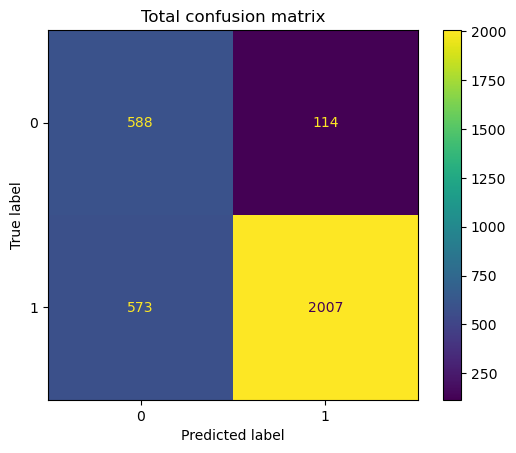

In [8]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

final_model = Pipeline([('smote', SMOTE(random_state=509)),
                        ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.005, random_state=206))])

final_model_summary = test_model_performance(final_model, df_train, df_test, features)

In [9]:
final_model_summary

,Test Year,Balanced accuracy,Precision,Recall,NPV,Specificity,Uncalibrated Brier,Calibrated Brier
0,2017,0.803208,0.942424,0.754854,0.519048,0.851562,0.144688,0.118677
1,2018,0.806346,0.927954,0.805000,0.573770,0.807692,0.141943,0.123782
2,2019,0.810161,0.962099,0.758621,0.435484,0.861702,0.152594,0.108594
3,2020,0.786667,0.950820,0.773333,0.413793,0.800000,0.149894,0.101055
4,2021,0.848844,0.939948,0.831409,0.671171,0.866279,0.121111,0.112767
5,2022,0.782424,0.954545,0.746667,0.387097,0.818182,0.163364,0.114470


In [10]:
final_model_summary.mean().drop("Test Year")

Balanced accuracy     0.806275
Precision             0.946298
Recall                0.778314
NPV                   0.500061
Specificity           0.834236
Uncalibrated Brier    0.145599
Calibrated Brier      0.113224
dtype: float64

## Calibration curves

Below we compare the calibration curves for the uncalibrated model and the calibrated model, each evaluated on the test set.

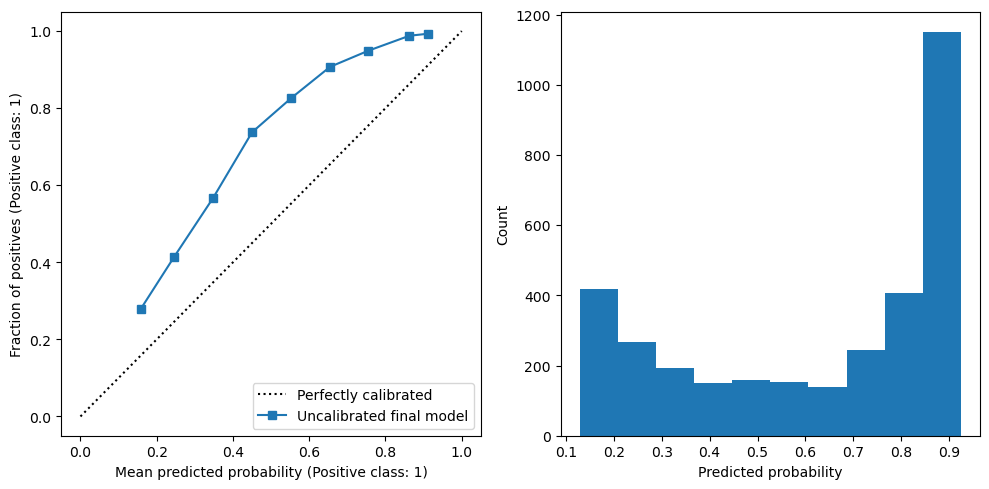

Brier score: 0.12962815527498703


In [11]:
display_calibration(final_model, df_test, features, "Uncalibrated final model")

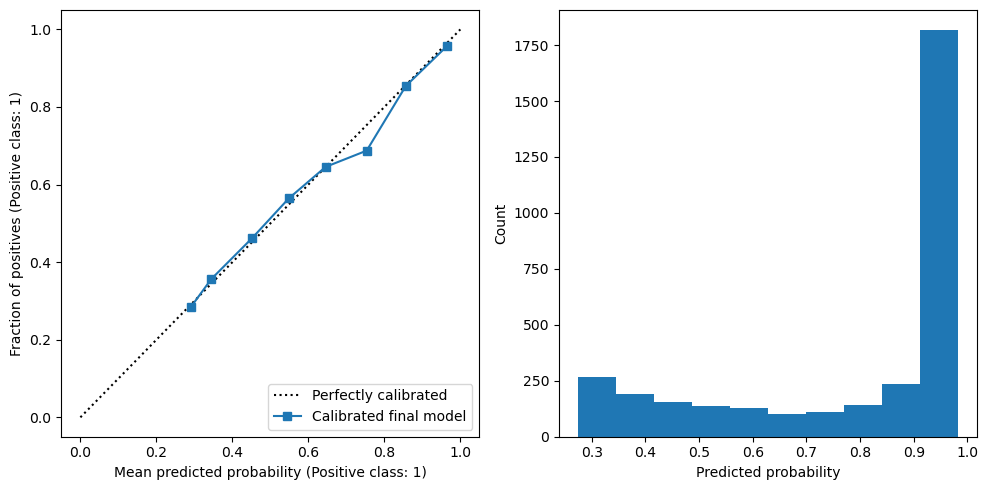

Brier score: 0.11380579305024069


In [12]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

df_tt, df_cal = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=5, stratify=df_train.IN_LEAGUE_NEXT)

model = Pipeline([('smote', SMOTE(random_state=509)),
                  ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.005, random_state=206))])

model.fit(df_tt[features], df_tt.IN_LEAGUE_NEXT)

final_model_cal = CalibratedClassifierCV(model, cv="prefit")
final_model_cal.fit(df_cal[features], df_cal.IN_LEAGUE_NEXT)

display_calibration(final_model_cal, df_test, features, "Calibrated final model")

## Conclusions

In [55]:
pd.DataFrame({"Baseline": baseline_summary.mean().drop("Test Year"),
              "XGBoost w. SMOTE": final_model_summary.mean().drop("Test Year")})

,Baseline,XGBoost w. SMOTE
Balanced accuracy,0.500000,0.806275
Precision,0.787576,0.946298
Recall,1.000000,0.778314
NPV,0.000000,0.500061
Specificity,0.000000,0.834236
Uncalibrated Brier,0.212424,0.145599
Calibrated Brier,0.167782,0.113224


Our final model demonstrated strong performance in predicting whether NBA players would remain in the league. On the test set, it achieved a **balanced accuracy of 81%**, indicating robust performance across both classes. Notably, the model achieved a **precision of 95%**, reflecting high confidence in predicting players who stayed, and a **recall of 78%**, ensuring most players who stayed were correctly identified. Its **specificity of 83%** further highlights its ability to correctly identify players who left. While the **negative predictive value (NPV) of 50%** appears lower, this is expected given the model's prioritization of minimizing false positives (high precision) and achieving balanced accuracy (strong recall and specificity). Incorporating additional factors such as G-League data, contract terms, and injuries could likely improve the NPV.

For both the baseline and XGBoost models, fitting a calibrator improved the Brier score, as expected.  The Brier scores for the XGBoost model are significantly better than those for the baseline.

To help visualize our results, let's take a random sample of 10 players from the 2022-2023 season and look at our predictions. The plot below shows the predicted probabilities of these players staying in the league; the red dashed line marks the decision threshold of 0.5, and the color of a bar indicates whether the prediction was correct (blue) or incorrect (orange).  Black horizontal ticks denote the predicted probabilities from the calibrator; note that these are not used to make the classification.

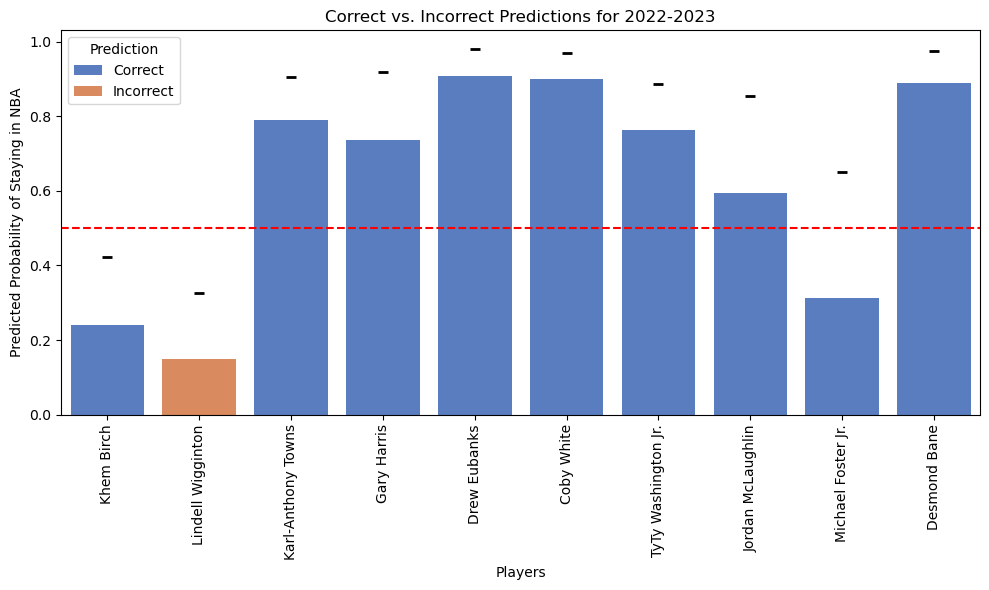

In [52]:
# get data for 2022-23 season
df_2022 = df_test.loc[df_test['SEASON_START']==2022].copy()

# create columns from predict and predict_proba
df_2022['PREDICT'] = final_model.predict(df_2022[features])
df_2022['PREDICT_PROBA'] = final_model.predict_proba(df_2022[features])[:,1]
df_2022['PREDICT_PROBA_CAL'] = final_model_cal.predict_proba(df_2022[features])[:,1]

# take a sample of 50 players
df = df_2022.sample(10, random_state=45).copy()

# create column indicating whether prediction was correct
df['CORRECT'] = (df['PREDICT'] == df['IN_LEAGUE_NEXT'])
df['CORRECT'] = df['CORRECT'].map({True: 'Correct', False: 'Incorrect'})

# plot predict_proba and show correct vs. incorrect predictions
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='NAME', y='PREDICT_PROBA', hue='CORRECT', hue_order=['Correct', 'Incorrect'], palette='muted')
sns.pointplot(data=df, x="NAME", y="PREDICT_PROBA_CAL", ax=ax, linestyles="None", color='k', marker="_")
plt.axhline(0.5, color='r', linestyle='--')
plt.title('Correct vs. Incorrect Predictions for 2022-2023')
plt.ylabel('Predicted Probability of Staying in NBA')
plt.xlabel('Players')
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Prediction', loc='upper left')
plt.tight_layout()
plt.show()

We note the following observations:
* All of the players with predicted probabilities above 50% were correctly classified, consistent with the model's high precision.

* The one incorrect classification is a false negative, so Lindell Wigginton was predicted to be out of the NBA in the 2023 season but managed to hang on.  That said, he only played 3 games for Milkwaukee before being waived, and he hasn't made a return to the NBA since.